In [4]:
import os
import torch
import random
import numpy as np
from numpy.linalg import det
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import norm
from scipy.stats.distributions import chi2
from random import shuffle
from matplotlib.animation import FuncAnimation
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky

## Creating Dataset

In [5]:
# Fix seeds
random.seed(15)
np.random.seed(15)
torch.manual_seed(15)


c1 = plt.get_cmap('coolwarm')(0.0)
c2 = plt.get_cmap('coolwarm')(1.0)

plt_cmap = sns.color_palette("coolwarm", as_cmap=True)

In [6]:
def make_dataset(mean, cov, v=None, separation=1, n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [7]:
n_dim = 2
n_classes = 2
n_datasets = 4
device = 'cpu'

In [8]:
mu = np.array([0, 0])
separation = 6
A = np.random.randn(2, 2)
cov = .1 * np.dot(A.T, A) + np.eye(2)
v = np.array([np.cos((np.pi / 180) * 45), np.sin((np.pi / 180) * 45)])
X, y = make_dataset(mu, cov, v=v, separation=separation, n=400)
Xt = torch.from_numpy(X).float()
Yt = torch.nn.functional.one_hot(torch.from_numpy(y).long(), num_classes=2).float()

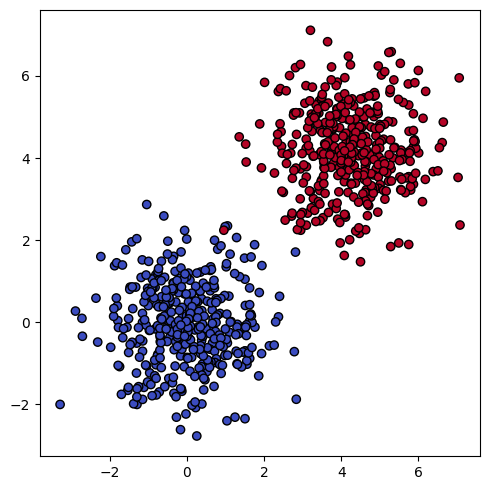

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=Xt[:, 0], y=Xt[:, 1], c=y, cmap='coolwarm', edgecolor='k')
plt.tight_layout()

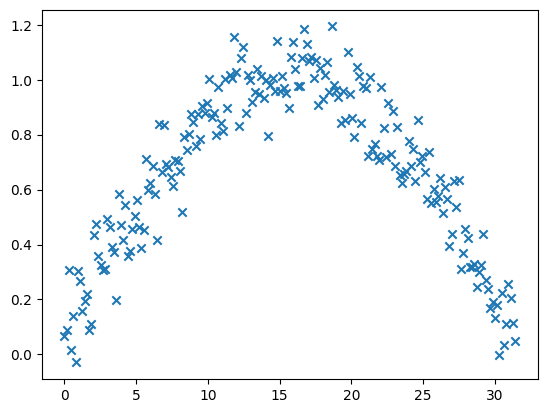

In [10]:
abs = np.linspace(0, 10*np.pi, 200)
np.random.seed(None)
def arc(x):
    return np.sin(x/10) + np.random.normal(0.05, 0.1, 200)

X_arc = np.concatenate((abs.reshape((200, 1)), arc(abs).reshape((200, 1))), axis=1)

fig, ax = plt.subplots(1, 1)
ax.scatter(X_arc[:, 0], X_arc[:, 1], marker = 'x')

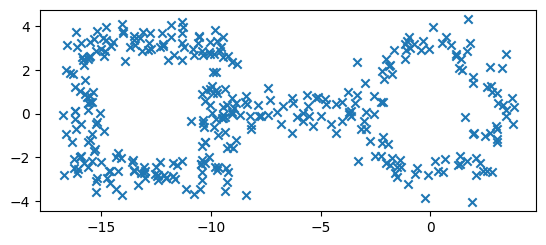

In [11]:
# Number of data points for each component
num_points = 100

# Generate data for a ring
radius = 3
theta_ring = np.linspace(0, 2 * np.pi, num_points)
ring_x = radius * np.cos(theta_ring)
ring_y = radius * np.sin(theta_ring)

# Define the side length of the square
side_length = 6

# Generate points for all sides of the square

# Generate points for the bottom side of the square
bottom_x = np.linspace(-10 - side_length, -10, num_points//2)
bottom_y = np.full(num_points//2, -side_length / 2)

# Generate points for the top side of the square
top_x = np.linspace(-10 - side_length, -10, num_points//2)  # Reversed order
top_y = np.full(num_points//2, side_length / 2)

# Generate points for the left side of the square
left_x = np.full(num_points//2, -10 - side_length)
left_y = np.linspace(-side_length / 2, side_length / 2, num_points//2)

# Generate points for the right side of the square
right_x = np.full(num_points//2, -10)
right_y = np.linspace(side_length / 2, -side_length / 2, num_points//2)  # Reversed order

# Combine all points to create the square dataset
square_x = np.concatenate((bottom_x, right_x, top_x, left_x))
square_y = np.concatenate((bottom_y, right_y, top_y, left_y))

# Generate data for a connecting line
line_x = np.linspace(-3, -10, num_points//2)
line_y = np.zeros(num_points//2)

# Combine the datasets
x = np.concatenate((ring_x, square_x, line_x))
y = np.concatenate((ring_y, square_y, line_y))

x += np.random.normal(0.2, 0.5, len(x))
y += np.random.normal(0.2, 0.5, len(y))

X_ring_and_square = np.concatenate((x.reshape((len(x), 1)), y.reshape((len(y), 1))), axis=1)

plt.scatter(x, y, marker='x')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Python Implementation of Incremental Learning based on Growing Gaussian Mixture Models

Global variables

In [12]:
a = 0.8

Utility functions

In [48]:
def plot_GMM(GMM, limits, fig, ax):

    for i in range(len(GMM)):
        # Define the mean and covariance matrix
        mean = GMM[i][2]
        cov_matrix = GMM[i][3]

        # Calculate the eigenvalues and eigenvectors of the covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # Calculate the angle of rotation for the ellipse
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

        # Plot the mean of the gaussian
        ax.scatter(mean[0], y=mean[1], marker = 'x', color='g', zorder=2)

        # Create and add the ellipse to the plot
        ellipse = patches.Ellipse(xy=mean, width=2 * np.sqrt(5.991 * eigenvalues[0]), height=2 * np.sqrt(5.991 * eigenvalues[1]),
                                angle=angle, fill=False, color='b')
        ax.add_patch(ellipse)

        # Set axis limits
        ax.set_xlim(limits[0][0]-5, limits[0][1]+5)
        ax.set_ylim(limits[1][0]-3, limits[1][1]+3)

def split(gauss):
    eigenvalues, eigenvectors = np.linalg.eigh(gauss[3])
    lamb_i = np.argmax(eigenvalues)
    nu = eigenvectors[:, lamb_i]
    delta_nu = np.sqrt(a*eigenvalues[lamb_i]) * nu
    tau = gauss[0]/2
    c = gauss[1]/2
    mu1 = gauss[2] + delta_nu
    mu2 = gauss[2] - delta_nu
    sigma = gauss[3] - np.outer(delta_nu, delta_nu)
    return [tau, c, mu1, sigma], [tau, c, mu2, sigma]

def merge(gauss1, gauss2):
    merged_weight = gauss1[0] + gauss2[0]
    merged_c = gauss1[1] + gauss2[1]
    f1 = gauss1[0]/merged_weight
    f2 = gauss2[0]/merged_weight
    merged_mean = f1 * gauss1[2] + f2 * gauss2[2]
    merged_cov = f1 * gauss1[3] + f2 * gauss2[3] \
                + f1 * f2 * np.outer(gauss1[2] - gauss2[2], gauss1[2] - gauss2[2])
    merged_gauss = [merged_weight, merged_c, merged_mean, merged_cov]
    return merged_gauss

def sqrtm(A, return_inv=False):
    D, V = torch.linalg.eig(A)

    A_sqrt = torch.mm(V, torch.mm(torch.diag(D.pow(1 / 2)), V.T)).real
    if return_inv:
        A_sqrt_neg = torch.mm(V, torch.mm(torch.diag(D.pow(-1 / 2)), V.T)).real
        return A_sqrt, A_sqrt_neg
    return A_sqrt

def bures_wasserstein_metric(mean1, mean2, cov1, cov2):
    sqrt_src_cov = sqrtm(cov1)

    M = sqrtm(torch.mm(sqrt_src_cov, torch.mm(cov2, sqrt_src_cov)))
    bures_metric = torch.trace(cov1) + torch.trace(cov2) - 2 * torch.trace(M)

    return torch.sqrt(torch.dist(mean1, mean2, p=2) ** 2 + bures_metric)

def nearest_psd(M):
    eigval, eigvec = np.linalg.eigh(M)
    nearest_psd = np.dot(eigvec, np.dot(np.diag(np.maximum(eigval, 1e-5)), eigvec.T))
    return nearest_psd

def init_cov_and_T_split(K_max, range_data, n):
    cov_init_size = range_data/(2*K_max)
    cov_init = cov_init_size*np.eye(n)
    T_split = 2*np.linalg.det(cov_init)
    return cov_init, T_split

def normal_pdf(x, mean, cov):
    return (2*np.pi)**(-len(x)/2) * np.linalg.det(cov)**(-1/2) * np.exp(-1/2 * np.dot((x - mean).T, np.dot(np.linalg.inv(cov), (x - mean))))

def log_normal_pdf(x, mean, cov):
    return -len(x)/2*np.log(2*np.pi) - 1/2*(np.log(np.linalg.det(cov)) + np.dot((x - mean).T, np.dot(np.linalg.inv(cov), (x - mean))))

In [49]:
def GGMM(X, K_max, sigma0, alpha, T_split):
    GMM = []
    for i in range(len(X)):
        new_x = X[i]
        P = np.zeros(len(GMM))
        for j in range(len(GMM)):
            P[j] = GMM[j][0] * normal_pdf(new_x, GMM[j][2], GMM[j][3])
        if len(GMM) > 0 and np.sum(P) == 0:
            dist = [np.linalg.norm(new_x - GMM[k][2]) for k in range(len(GMM))]
            P[np.argmin(dist)] = 1
        if len(GMM) < K_max:
            GMM.append([alpha, 1, new_x, sigma0])
        else:
            Q = P/np.sum(P)
            for j in range(len(GMM)):
                GMM[j][1] = GMM[j][1] + Q[j]
                GMM[j][0] = (1 - alpha) * GMM[j][0] + alpha * Q[j]
                eta_j = Q[j]*((1-alpha)/GMM[j][1] + alpha)
                GMM[j][2], GMM[j][3] = (1 - eta_j)*GMM[j][2] + eta_j*new_x, \
                                        (1 - eta_j)*GMM[j][3] + eta_j*np.outer(new_x - GMM[j][2], new_x - GMM[j][2])
        total_weight = np.sum([GMM[j][0] for j in range(len(GMM))])
        for j in range(len(GMM)):
            GMM[j][0] = GMM[j][0]/total_weight
        
        # Split and merge
        if len(GMM) > 0:
            
            # Split
            V = [np.linalg.det(GMM[j][3]) for j in range(len(GMM))]
            s = np.argmax(V)
            if V[s] > T_split:
                gauss_split1, gauss_split2 = split(GMM[s])
                del GMM[s]
                GMM.append(gauss_split1)
                GMM.append(gauss_split2)
            
            # Merge
            while len(GMM) > K_max:
                bwm = np.full((len(GMM), len(GMM)), np.inf)
                for i in range(len(GMM)):
                    for j in range(i):
                        gauss1 = GMM[i]
                        gauss2 = GMM[j]
                        mean1 = torch.from_numpy(gauss1[2]).float()
                        mean2 = torch.from_numpy(gauss2[2]).float()
                        cov1 = torch.from_numpy(gauss1[3]).float()
                        cov2 = torch.from_numpy(gauss2[3]).float()
                        bwm[i, j] = bures_wasserstein_metric(mean1, mean2, cov1, cov2)
                min_value = np.min(bwm)
                min_indexes = np.argwhere(bwm == min_value)[0]
                merged_gauss = merge(GMM[min_indexes[0]], GMM[min_indexes[1]])
                del GMM[max(min_indexes[0], min_indexes[1])]
                del GMM[min(min_indexes[0], min_indexes[1])]
                GMM.append(merged_gauss)   
        
            
    return GMM

[]
[0.03275115]
[1.01462121e-25 1.65045010e-35]
[1.79253157e-12 2.24441162e-14 6.58156723e-20]
[2.66929357e-08 3.22945933e-05 9.80609648e-56 8.47076791e-21]
[8.15596416e-03 1.24262128e-02 2.99620524e-39 2.60585785e-17
 9.36702649e-05]
[4.10788049e-12 1.36872637e-18 9.79557414e-06 1.77220227e-09
 8.96056744e-33 3.28577123e-21]
[1.29891903e-11 1.70566034e-07 5.92693580e-62 3.92204764e-22
 8.19678373e-03 5.15756169e-07 3.15943098e-37]
[1.20621804e-10 3.18590349e-07 3.35776622e-53 2.79785526e-15
 6.76108408e-04 1.63830354e-07 1.29721166e-30 2.91661498e-03]
[5.31290352e-35 9.57625477e-45 1.88824566e-04 4.90209200e-20
 6.18448946e-65 2.97539500e-49 8.34229308e-09 4.51720570e-70
 7.62350163e-59]
[1.72407621e-14 6.11714515e-17 2.92636383e-18 9.82365226e-03
 2.82036712e-24 5.68181543e-20 8.13588679e-09 1.55963760e-25
 5.77280872e-18 2.96204670e-17]
[3.18546467e-11 1.50063136e-14 2.76917218e-14 2.60910095e-03
 2.46310239e-23 2.77419778e-17 7.09033614e-06 1.95431116e-25
 1.50143139e-18 7.16024469

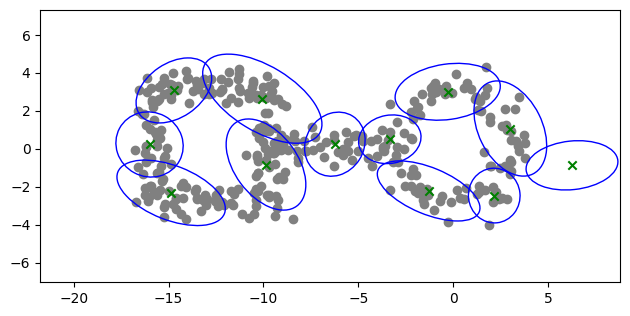

In [51]:
data = np.random.permutation(X_ring_and_square)

xmin, ymin = np.min(data, axis=0)[0], np.min(data, axis=0)[1]
xmax, ymax = np.max(data, axis=0)[0], np.max(data, axis=0)[1]
limits = [[xmin, xmax], [ymin, ymax]]
range_data = np.mean(np.max(X_ring_and_square, axis=0) - np.min(X_ring_and_square, axis=0))

K_max = 12
cov_init, T_split = init_cov_and_T_split(K_max, range_data, data.shape[1])

result = GGMM(data, K_max, cov_init, 0.1, T_split)

fig, ax = plt.subplots()
ax.scatter(x=data[:, 0], y=data[:, 1], color='grey', zorder = 1)
plot_GMM(result, limits, fig, ax)
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

In [53]:
dataset_MGR = np.load(os.path.join('MGR_usecase','MGR.npy'))

data_noiseless = dataset_MGR[:1000, :]
# feature column 17 is only zeros
data_noiseless = np.delete(data_noiseless, 17, axis=1)

# separation between training and validation data
data_noiseless = np.random.permutation(data_noiseless)
prop_train = 0.8
data_train = data_noiseless[:int(prop_train * len(data_noiseless)), :]
data_test = data_noiseless[int(prop_train * len(data_noiseless)):, :]


# Features of the noiseless data
X_train = data_train[:, :-2]
X_test = data_test[:, :-2]

# Labels of the noiseless data
y_train = data_train[:, -2]
y_test = data_test[:, -2]

In [59]:
range_data = np.mean(np.max(X_train, axis=0) - np.min(X_train, axis=0))

K_max = 10
cov_init, T_split = init_cov_and_T_split(K_max, range_data, X_train.shape[1])

result = GGMM(X_train, K_max, cov_init, 0.1, T_split)

[]
[1.]
[0. 1.]
[1. 0. 0.]
[0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 2.03016542e-236]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0

In [57]:
result

[[1.3689149012611954e-08,
  8.0,
  array([ 3.55711979e-01,  8.93556214e-02,  1.45276593e-01,  5.06055487e-03,
          2.08701650e+03,  4.42446114e+05,  2.03031533e+03,  1.50741103e+05,
          4.29352660e+03,  1.65101051e+06,  1.01632235e-01,  2.48380141e-03,
         -1.49218835e-04,  1.36699242e-02, -4.76923509e-04,  6.36803658e-03,
          1.04614919e+02, -1.29912108e+02,  6.30044336e+03,  1.04252894e+02,
          1.05636326e+03, -1.95597558e+01,  6.35485604e+02,  3.96829331e+01,
          3.18501157e+02,  1.63738791e+00,  4.43308192e+02,  1.25297238e+01,
          1.97729995e+02, -1.17779787e+01,  1.35708597e+02,  9.24797749e+00,
          1.45978482e+02, -1.07199729e+01,  1.19450573e+02,  4.24580871e+00,
          1.44413553e+02, -7.24106526e+00,  8.72712883e+01,  1.90304526e-01,
          7.81631747e+01, -6.53211946e+00,  6.90787405e+01, -2.91133979e+00,
          6.41133749e+01, -7.35855037e+00,  7.00220362e+01, -3.19758416e+00,
          6.56030688e+01, -7.04026134e+00, 